In [1]:
import pandas as pd
import json
from elasticsearch import Elasticsearch

/Users/amoghkulkarni/.local/share/virtualenvs/python_practice-ZCCdr_2d/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [24]:
from tqdm.auto import tqdm

In [2]:
with open('documents-with-ids.json', 'rt') as f_in:
    documents = json.load(f_in)

In [3]:
from sentence_transformers import SentenceTransformer

In [4]:
df_ground_truth = pd.read_csv('../module-3/ground-truth-data.csv')

In [5]:
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [6]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [7]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [8]:
es_client = Elasticsearch('http://localhost:9200') 

In [9]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [11]:
index_name = "course-questions"

In [12]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

In [13]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [67]:
from huggingface_hub import InferenceClient
import os

In [121]:
HF_API_TOKEN = os.getenv('HF_API_TOKEN')
client = InferenceClient("HuggingFaceH4/zephyr-7b-beta", token=HF_API_TOKEN)

In [16]:
def llm(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat_completion(messages, max_tokens=1000)
    
    return response.choices[0].message.content

In [18]:
# previously: rag(query: str) -> str
def rag(query: dict) -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt)
    return answer

In [19]:
rag(ground_truth[10])

'QUESTION: Are sessions recorded if I miss one?\n\nANSWER (based on context): Yes, everything is recorded, including office hours sessions. You can ask questions in advance, and they will be covered during the live stream. Additionally, you can always ask questions in Slack.'

In [20]:
df_gpt40_mini = pd.read_csv('results-gpt4o-mini.csv')

In [21]:
df_gpt40_mini

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp
...,...,...,...,...,...
1825,Some suggested titles for listing the Machine ...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp
1826,It is best advised that you do not list the Ma...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp
1827,You can incorporate your Machine Learning Zoom...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp
1828,The advice on including a project link in a CV...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp


In [22]:
len(ground_truth)

1830

In [48]:
sample_ground_truth = ground_truth[:100].copy()

In [73]:
answers = {}

In [60]:
answers

{}

In [ ]:
## rate limit reached. wait for an hour after 12 PM.

In [74]:
for i, rec in enumerate(tqdm(sample_ground_truth)):

    if i in answers:
        continue
    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course']
    }

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
doc_key_list = list(doc_idx.keys())

In [36]:
doc_key_list[:10]

['c02e79ef',
 '1f6520ca',
 '7842b56a',
 '0bbf41ec',
 '63394d91',
 '2ed9b986',
 '93e2c8ed',
 'a482086d',
 'eb56ae98',
 '4292531b']

In [52]:
answer_llm = rag(rec)

In [53]:
rec

{'question': 'Are the majority of modules unchanged from the 2022 course?',
 'course': 'machine-learning-zoomcamp',
 'document': '94e86808'}

In [54]:
answer_llm

'QUESTION: Are the majority of modules unchanged from the 2022 course?\n\nANSWER: Yes, according to the context provided, the majority of modules in the current course (2023) are the same as in the 2022 course, with the exception of one special module (BentoML) that was offered in the previous iteration. The rest of the modules are unchanged.'

In [55]:
doc_id = rec['document']

In [56]:
doc_id

'94e86808'

In [57]:
original_doc = doc_idx[doc_id]

In [58]:
original_doc

{'text': 'There’s not much difference. There was one special module (BentoML) in the previous iteration of the course, but the rest of the modules are the same as in 2022. The homework this year is different.',
 'section': 'General course-related questions',
 'question': 'What’s the difference between the previous iteration of the course (2022) and this one (2023)?',
 'course': 'machine-learning-zoomcamp',
 'id': '94e86808'}

In [63]:
answers['0227b872']

{'answer_llm': "When structuring your questions and answers for the course, it's important to follow the guidance provided by the course Teaching Assistant, Alexey Grigorev, who stated that the project is graded based on the total score earned by all students to ensure that most pass. To structure your questions, it might be helpful to ask specific questions related to the course materials and activities. This can include questions about the course's duration, next steps for new joiners, and recommended study schedule. It's also important to consider whether other languages can be used in the course and the potential consequences of doing so. In terms of answers, it's helpful to provide clear and concise explanations, and to include any relevant links or resources. Additionally, it can be helpful to provide your own experiences or insights related to the course materials to help other students better understand the concepts being taught. Here's an example of a well-structured question 

In [64]:
doc_idx['0227b872']

{'text': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'section': 'General course-related questions',
 'question': 'How do I sign up?',
 'course': 'machine-learning-zoomcamp',
 'id': '0227b872'}

In [76]:
answers[3]

{'answer_llm': "QUESTION: Does this course have a GitHub repository for the sign-up link?\n\nANSWER: It is not explicitly stated in the provided context whether the course has a GitHub repository for the sign-up link. You should check the course materials or contact the course instructor for more information. However, provided answers from the context suggest that the course encourages students to create their own GitHub repositories for sharing notes, homework, and projects. It also mentions that a public GitHub repository is required for receiving grades for homework. Therefore, it's possible that the sign-up link for the course is provided in a public GitHub repository associated with the course.",
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData

In [ ]:
sample_ground_truth

In [79]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']

    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)

    return v_llm.dot(v_orig)

In [75]:
results_gpt4o = df_gpt40_mini.to_dict(orient='records')

In [77]:
results_gpt4o[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [81]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [82]:
df_gpt40_mini['cosine'] = similarity

In [83]:
df_gpt40_mini

,answer_llm,answer_orig,document,question,course,cosine
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.388595
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,0.298360
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,0.583048
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,-0.019481
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,0.358467
...,...,...,...,...,...,...
1825,Some suggested titles for listing the Machine ...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp,0.620891
1826,It is best advised that you do not list the Ma...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp,0.730319
1827,You can incorporate your Machine Learning Zoom...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp,0.679815
1828,The advice on including a project link in a CV...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp,0.355928


In [85]:
df_gpt40_mini.iloc[3].to_dict()

{'answer_llm': 'The context does not provide any specific information about a GitHub repository for the sign-up link for the course. Therefore, I cannot confirm whether or not such a repository exists.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Does this course have a GitHub repository for the sign-up link?',
 'course': 'machine-learning-zoomcamp',
 'cosine': -0.019480830058455467}

In [87]:
df_gpt40_mini.describe()

,cosine
count,1830.000000
mean,0.680332
std,0.215962
min,-0.141910
25%,0.585866
50%,0.733998
75%,0.836750
max,0.982701


In [93]:
df_mistral_zephyr = pd.DataFrame(answers.values())

In [97]:
results_zephyr = df_mistral_zephyr.to_dict(orient='records')

In [98]:
zephyr_similarity = []

for record in tqdm(results_zephyr):
    sim = compute_similarity(record)
    zephyr_similarity.append(sim)

  0%|          | 0/100 [00:00<?, ?it/s]

In [99]:
df_mistral_zephyr['cosine'] = zephyr_similarity

In [102]:
df_mistral_zephyr

,answer_llm,answer_orig,document,question,course,cosine
0,QUESTION: How can I sign up for the course?\n\...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.392704
1,"Based on the context provided, the answer to t...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,0.506155
2,"Based on the given context, the answer to the ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,0.330518
3,QUESTION: Does this course have a GitHub repos...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,-0.014857
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,0.266619
...,...,...,...,...,...,...
95,"In summary, the main difference between the 20...",There’s not much difference. There was one spe...,94e86808,What has changed between the 2022 and 2023 ver...,machine-learning-zoomcamp,0.779869
96,"Based on the context provided, the answer to t...",There’s not much difference. There was one spe...,94e86808,Is there any module missing in the 2023 course...,machine-learning-zoomcamp,0.568982
97,QUESTION: Are the homework assignments in the ...,There’s not much difference. There was one spe...,94e86808,Are the homework assignments in the 2023 cours...,machine-learning-zoomcamp,0.644507
98,"Based on the context provided, yes, BentoML wa...",There’s not much difference. There was one spe...,94e86808,Was BentoML included in the 2022 course but no...,machine-learning-zoomcamp,0.682804


In [104]:
df_mistral_zephyr.describe()

,cosine
count,100.000000
mean,0.571295
std,0.213279
min,-0.014857
25%,0.496798
50%,0.632217
75%,0.720342
max,0.850409


In [105]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 772.2 kB/s eta 0:00:001m835.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.4 MB/s eta 0:00:003.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 4.2 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.3 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.7 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 3.1 MB/s eta 0:00:000m eta 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [106]:
import seaborn as sns

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the f

/var/folders/zw/mqwlds_s7ml5_fvqptkb174h0000gn/T/ipykernel_12306/2489636975.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt40_mini['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

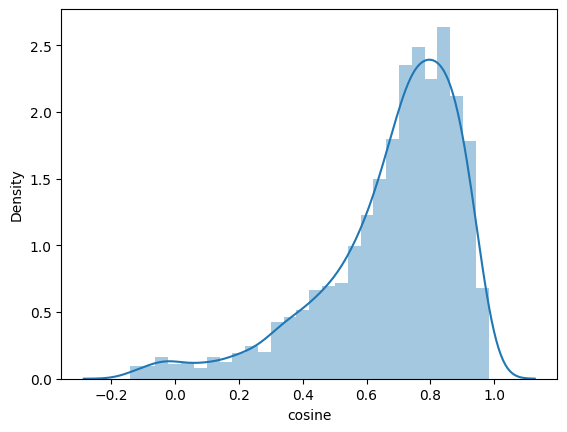

In [107]:
sns.distplot(df_gpt40_mini['cosine'])

In [109]:
import matplotlib.pyplot as plt

/var/folders/zw/mqwlds_s7ml5_fvqptkb174h0000gn/T/ipykernel_12306/1020501571.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt40_mini['cosine'], label='4o')
/var/folders/zw/mqwlds_s7ml5_fvqptkb174h0000gn/T/ipykernel_12306/1020501571.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_

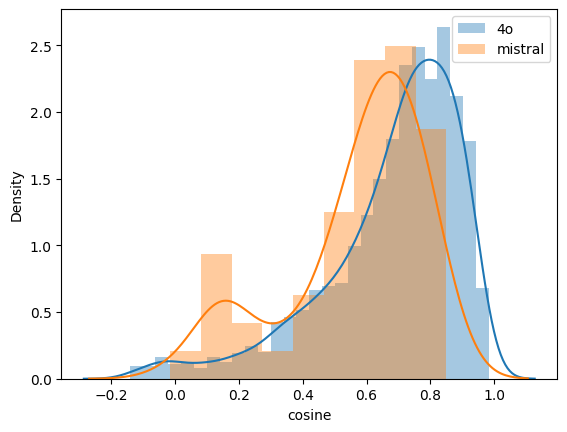

In [110]:
sns.distplot(df_gpt40_mini['cosine'], label='4o')
sns.distplot(df_mistral_zephyr['cosine'], label='mistral')

plt.legend()

In [111]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [112]:
df_4o_sample = df_gpt40_mini.sample(n=150, random_state=1)

In [115]:
samples_4o = df_4o_sample.to_dict(orient='records')

In [116]:
record =samples_4o[0]

In [119]:
prompt = prompt1_template.format(**record)

In [122]:
llm(prompt)

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides a complete and accurate explanation of the syntax required to use the precision_recall_fscore_support function in Python, making it a relevant answer when compared to the original answer."\n}'

In [123]:
json

<module 'json' from '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/json/__init__.py'>

In [124]:
answer = json.loads('{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides a complete and accurate explanation of the syntax required to use the precision_recall_fscore_support function in Python, making it a relevant answer when compared to the original answer."\n}')

In [125]:
answer

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer provides a complete and accurate explanation of the syntax required to use the precision_recall_fscore_support function in Python, making it a relevant answer when compared to the original answer.'}

In [126]:
answers = []

for each_record in tqdm(samples_4o):
    answer = llm(prompt1_template.format(**each_record))
    answers.append(answer)

  0%|          | 0/150 [00:00<?, ?it/s]

In [127]:
answers[140]

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides a detailed explanation and a link to the TensorFlow documentation, which fully addresses the requested information on using \'workers\' in \'model.fit()\'. Therefore, the relevance is \'RELEVANT\'."\n}'

In [171]:
json_answers = []

for i, each_answer in enumerate(tqdm(answers)):
    if "<|user|" in each_answer:
        each_answer = each_answer.split("<|user|")[0]
    json_answers.append(json.loads(each_answer))

  0%|          | 0/150 [00:00<?, ?it/s]

In [162]:
i

126

In [163]:
answers[i]

'```json\n{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides a detailed solution to the error encountered with ImageDataGenerator related to scipy. It covers the necessary steps to resolve the issue which aligns with the original answer provided."\n}\n```'

In [157]:
answers[i].replace("\'", "")

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer accurately explains the cause of Failed to import module "service": No module named sklearn error in bentoml and provides a solution to fix it by modifying the packages list in `bentofile.yaml`, which is directly related to the original answer provided."\n}'

In [160]:
answers[i] = answers[i].replace("\'", "").replace('"service"', 'service')

In [170]:
answers[i] = answers[i].replace("```", "").replace("json", "")

In [172]:
json_answers[10]

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer provides a solution to the error mentioned in the original answer, making it completely relevant.'}

In [173]:
df_evaluations = pd.DataFrame(json_answers)

In [174]:
df_evaluations

,Relevance,Explanation
0,RELEVANT,The generated answer provides a complete and a...
1,RELEVANT,The generated answer accurately describes the ...
2,RELEVANT,The generated answer accurately and completely...
3,PARTLY_RELEVANT,The generated answer provides information on w...
4,NON_RELEVANT,The generated answer does not directly address...
...,...,...
145,RELEVANT,The generated answer fully addresses the issue...
146,RELEVANT,The generated answer directly addresses the us...
147,RELEVANT,The generated answer accurately explains the r...
148,RELEVANT,The generated answer accurately and comprehens...


In [175]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT              108
PARTLY_RELEVANT        21
NON_RELEVANT           19
PARTIALLY_RELEVANT      2
Name: count, dtype: int64

In [176]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
4,NON_RELEVANT,The generated answer does not directly address...
11,NON_RELEVANT,The generated question and answer do not direc...
25,NON_RELEVANT,The generated answer provides a direct link to...
27,NON_RELEVANT,The Generated Answer is incorrect as it sugges...
31,NON_RELEVANT,The generated answer provides additional infor...
41,NON_RELEVANT,The generated question and answer are not dire...
43,NON_RELEVANT,The generated answer does not directly address...
44,NON_RELEVANT,The generated question is not related to the o...
45,NON_RELEVANT,The generated answer does not directly address...
49,NON_RELEVANT,The generated question is not directly related...


In [179]:
samples_4o[11]

{'answer_llm': 'To resolve the NotSupportedError in section 5, you can take the following steps:\n\n1. **Downgrade the protobuf package**: The recommended version is 3.20.1. You can do this by running the following command:\n   ```bash\n   pipenv install protobuf==3.20.1\n   ```\n\n2. **Regenerate your Protobuf files**: If you have access to the source files and can regenerate them, ensure that you use `protoc` version 3.19.0 or higher.\n\n3. **Alternative workaround**: If you cannot regenerate your protos, you can either downgrade the protobuf package to version 3.20.x or lower, or set the environment variable:\n   ```bash\n   export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python\n   ```\n   Note that the latter will use a slower pure-Python parser.\n\nMake sure to follow these steps to address the issue effectively.',
 'answer_orig': 'Question:\nWhen executing\neb local run  --port 9696\nI get the following error:\nERROR: NotSupportedError - You can use "eb local" only with preconfigu

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
```

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [181]:
answers_2 = []

for each_record in tqdm(samples_4o):
    answer = llm(prompt2_template.format(**each_record))
    answers_2.append(answer)

  0%|          | 0/150 [00:00<?, ?it/s]

In [214]:
json_evaluations_2 = []

for i, each_answer in enumerate(tqdm(answers_2)):
    if "<|user|" in each_answer:
        each_answer = each_answer.split("<|user|")[0]
    elif "json" in each_answer:
        each_answer = each_answer.replace("```", "").replace("json", "")
    json_eval = json.loads(each_answer)
    json_evaluations_2.append(json_eval)

  0%|          | 0/150 [00:00<?, ?it/s]

In [209]:
i

140

In [210]:
answers_2[i]

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides a direct answer to the question, as it provides a link to the TensorFlow documentation where more information about using the \'workers\' parameter in \'model.fit()\' can be found."\n} \n\nAlternatively, using a partial score:\n\n{\n  "Relevance": "PARTLY_RELEVANT",\n  "Explanation": "The generated answer provides some relevant information, as it mentions the \'workers\' parameter in \'model.fit()\', but might not be completely comprehensive regarding its usage. Further investigation outside the scope of the answer might be required to fully understand its capabilities."\n}'

In [213]:
answers_2[i] = answers_2[i].split("Alternatively")[0]

In [207]:
answers_2[i] = answers_2[i].replace("\'", "").replace('"service"', 'service')

In [215]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [216]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           136
PARTLY_RELEVANT      9
NON_RELEVANT         5
Name: count, dtype: int64

In [217]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
27,NON_RELEVANT,The provided generated answer states that if t...
45,NON_RELEVANT,The generated answer states that the provided ...
49,NON_RELEVANT,The generated answer does not provide a YouTub...
69,NON_RELEVANT,While the generated answer mentions an error o...
92,NON_RELEVANT,The question asks how to add notes to the Comm...


In [218]:
samples_4o[27]

{'answer_llm': 'If the region is configured by default, there is no alternative command mentioned in the provided context. The context specifically discusses using the command `aws configure` to set up various configurations, including the default region name.',
 'answer_orig': 'As per AWS documentation:\nhttps://docs.aws.amazon.com/AmazonECR/latest/userguide/docker-push-ecr-image.html\nYou need to do: (change the fields in red)\naws ecr get-login-password --region region | docker login --username AWS --password-stdin aws_account_id.dkr.ecr.region.amazonaws.com\nAlternatively you can run the following command without changing anything given you have a default region configured\naws ecr get-login-password --region $(aws configure get region) | docker login --username AWS --password-stdin "$(aws sts get-caller-identity --query "Account" --output text).dkr.ecr.$(aws configure get region).amazonaws.com"\nAdded by Humberto Rodriguez',
 'document': 'f9711723',
 'question': 'What is the alter